# Transfer learning with `ResNet`

In [175]:
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
from torchvision import transforms

In [176]:
import torchvision
import torch
from torchvision import models

In [177]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [178]:
transfer_model = models.resnet50(pretrained=True)

/Users/huyton/opt/anaconda3/envs/min_ds-env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/huyton/opt/anaconda3/envs/min_ds-env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Freeze the pretrained layers because we do not want to update their weights again

In [179]:
for name, param in transfer_model.named_parameters():
    if ("bn" not in name): # BatchNorm layers are trainable
        param.requires_grad = False

Replace the final layer with our wanted objectives

In [180]:
transfer_model.fc = nn.Sequential(
    nn.Linear(transfer_model.fc.in_features, 64),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(64, 10)
)

# Prepare data

Get DataSet

In [181]:
train_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_data = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


Reduce the size

In [182]:
train_data = torch.utils.data.Subset(train_data, range(10000))
test_data = torch.utils.data.Subset(test_data, range(1000))

In [183]:
# Split train data into: train & validation set
val_data = torch.utils.data.Subset(train_data, range(9000, 10000))
train_data = torch.utils.data.Subset(train_data, range(9000))

In [184]:
print(f"Train data: {len(train_data)}")
print(f"Validation data: {len(val_data)}")
print(f"Test data: {len(test_data)}")

Train data: 9000
Validation data: 1000
Test data: 1000


In [186]:
class_name = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

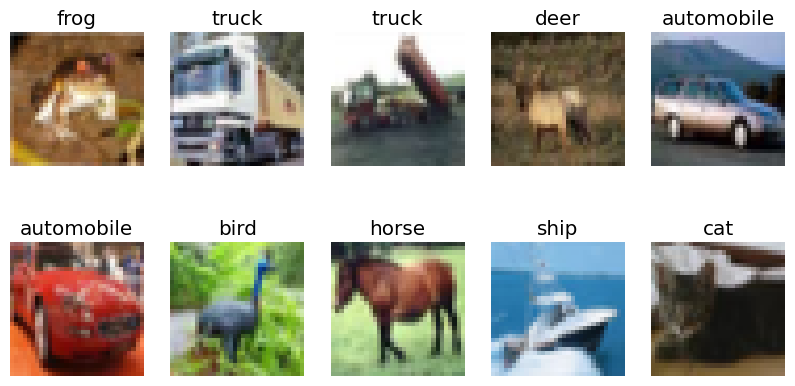

In [187]:
fig, ax = plt.subplots(2, 5, figsize=(10, 5))

for i in range(10):
    ax[i//5, i%5].imshow(train_data[i][0].permute(1, 2, 0))
    ax[i//5, i%5].set_title(class_name[train_data[i][1]])
    ax[i//5, i%5].axis('off')

Create DataLoader

In [188]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)

# Specify needed components

In [189]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(transfer_model.parameters(), lr=0.001)

# Training the model as usual

In [190]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=20, device='cpu'):

    train_loss = {}
    val_loss = {}

    for epoch in range(epochs):
        training_loss = 0.0
        valid_loss = 0.0
        model.train()
        
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch
            output = model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item()
        training_loss /= len(train_loader)
        train_loss[f'Epoch {epoch}'] = training_loss

        model.eval()
        num_correct = 0
        num_examples = 0
        for batch in val_loader:
            inputs, targets = batch
            output = model(inputs)
            loss = loss_fn(output, targets)
            valid_loss += loss.data.item()
            correct = torch.eq(torch.max(F.softmax(output, dim=1), dim=1)[1], targets)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
        valid_loss /= len(val_loader)
        val_loss[f'Epoch {epoch}'] = valid_loss

        print('Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, accuracy = {:.2f}'.format(epoch, training_loss, valid_loss, num_correct / num_examples))   

    return train_loss, val_loss

In [191]:
train_loss, val_loss = train(transfer_model,
                    optimizer,
                    loss_fn,
                    train_loader,
                    val_loader,
                    epochs=30)

Epoch: 0, Training Loss: 1.75, Validation Loss: 1.29, accuracy = 0.54
Epoch: 1, Training Loss: 1.18, Validation Loss: 1.15, accuracy = 0.58
Epoch: 2, Training Loss: 0.98, Validation Loss: 1.06, accuracy = 0.63
Epoch: 3, Training Loss: 0.86, Validation Loss: 1.01, accuracy = 0.65
Epoch: 4, Training Loss: 0.75, Validation Loss: 0.93, accuracy = 0.69
Epoch: 5, Training Loss: 0.69, Validation Loss: 0.92, accuracy = 0.69
Epoch: 6, Training Loss: 0.63, Validation Loss: 0.93, accuracy = 0.68
Epoch: 7, Training Loss: 0.57, Validation Loss: 0.91, accuracy = 0.70
Epoch: 8, Training Loss: 0.53, Validation Loss: 0.92, accuracy = 0.69
Epoch: 9, Training Loss: 0.50, Validation Loss: 0.96, accuracy = 0.70
Epoch: 10, Training Loss: 0.47, Validation Loss: 0.94, accuracy = 0.70
Epoch: 11, Training Loss: 0.43, Validation Loss: 0.89, accuracy = 0.72
Epoch: 12, Training Loss: 0.41, Validation Loss: 0.92, accuracy = 0.70
Epoch: 13, Training Loss: 0.37, Validation Loss: 0.95, accuracy = 0.70
Epoch: 14, Train